# 1. FELADAT

Ezt a feladatsort Python nyelven kell megoldani. A kimeneti adatok ábrázolásához minden esetben használjátok a jupyter notebookot! Az ábrák legyenek áttekinthetőek, és mindig szerepeljen rajtuk egyértelmű tengelyfelirat, azaz ahol adott az ábrázolt mennyiségek mértékegysége, azt is fel kell tüntetni! Lesznek a feladatsorban olyan kérdések, amelyekre a válaszok szabatosan megfogalmazott mondatok, amelyek hiányában a pontok töredéke érhető csak el.

Az feladatok megoldása az `ahkab` nevű áramkörszimulációs csomagra, és a `schemdraw` nevű, kapcsolási rajzok készítésére szolgáló csomagra támaszkodik.

Aki a feladatkidolgozás során kedvet kap, hogy saját számítógépére is telepítse ezeket a programokat, azt a legkönnyebben a `pip` programmal teheti meg, futtatva az alábbi parancsokat. (<font color='red'>Ezeket a parancsokat <strong>ne</strong> futtasd a kooplex környezetedben!</font>)

```
$ pip install git+https://github.com/ahkab/ahkab.git
$ pip install schemdraw
```

# Passzív áramkörök numerikus vizsgálata

Lineáris, időben állandó fizikai rendszerek vizsgálatakor gyakran foglalkozunk ideális elektronikus áramkörökkel, hiszen az elméleti érdekességeken túl ezek a gyakorlatban is igen fontosak. Az alábbi feladatok passzív elektronikai alkatrészekből (ellenállás, kondenzátor és induktivitás) megépíthető áramkörök viselkedését vizsgálják, de az alkalmazott módszerek a jelfeldolgozás területén általánosan használhatók. A feladatok megoldása során az `ahkab` áramkörszimulációs csomagot használjuk, mely nagy időfelbontással számítja ki az áramkör egyes csomópontjaiban megjelenő jelalakokat (időfüggő feszültségeket). Az ilyen szimuláció közelebb áll a valódi analóg áramkörök működéséhez, mint más, ún. diszkrét idejű rendszerek. Ezutóbbiak a digitális jelfeldolgozás modelljének tekinthetők.

A passzív elektronikai altrészek viselkedése a következő egyszerű fizikai törvényekkel írhatók le, ahol $u = u(t)$ az időfüggő feszültség, $i = i(t)$ az áram, $R$ az elleneállás, $C$ a kapacitás és $L$ az induktivitás:

* Ellenállás: $$ u = R i $$

* Kondenzátor: $$ \frac{du}{dt} = \frac{1}{C} i $$

* Induktivitás: $$ u = L \frac{di}{dt} $$

Konkrét áramkörök esetében az egyes komponensekre felírt differenciálegyenleteket a [Kirchhoff-törvények](https://hu.wikipedia.org/wiki/Kirchhoff-törvények) kapcsolják rendszerbe. Az egyenletek megoldásakor valamelyik bemeneti jelalakot (feszültség- vagy áramérték időbeli változását) előírjuk, és a rendszer erre adott válaszát, azaz egy kimeneti jelalak időfejlődését keressük.

Érdekes elméleti kérdés, hogy egy rendszer milyen választ ad egy nagyon rövid ideig tartó vizsgálóimpulzus esetében. Matematikailag az ilyen vizsgálóimpulzusokat Dirac-delta függvénnyel írjuk le, és ismert, hogy egy lineáris, időinvariáns rendszer válaszfüggvénye tetszőleges gerjesztés esetében meghatározható az **impulzusválasz** (más néven Green-függvény) és a gerjesztés konvolúciójaként:

$$
u_\mathrm{out}(t) = \int_{-\infty}^{t} u_\mathrm{in}(\tau) g(t-\tau) d\tau,
$$

ahol az, hogy az integrálás $t$-ig tart a rendszer kauzalitását fejezi ki.

Lineáris időinvariáns rendszereket érdemes Fourier-kifejtésben vizsgálni. Ilyenkor a rendszer szinuszos bemenő gerjesztésekre adott válaszát keressük, ami a tranziens viselkedés lecsengése után a linearitás miatt azonos frekvenciájú, szintén szinuszos jelalak lesz. Egy rendszer **átviteli függvénye** megadja, hogy egy $f$ frekvenciájú szinuszos gerjesztés esetében a rendszer mekkora csillapítást, illetve fázistolást okoz. Ismert, hogy Fourier-térben a konvolúció művelete a gerjesztés és az impulzusválasz Fourier-transzformáltjának szorzataként írható fel, és ebből az is következik, hogy az átviteli függvény az impulzusválasz Fourier-transzformáltja.

A feladatok során passzív áramköri elemekből összállított analóg szűrőket vizsgálunk, melyek az ún. Butterworth-topológiát követik. Az interneten elérhetők olyan eszközök, melyekkel különböző átviteli karakterisztikájú passzív vagy aktív szűrők tervezhetők, ld. pl.:    
    
* https://rf-tools.com/lc-filter/
* https://www.analog.com/designtools/en/filterwizard/

## Előre definiált függvények

Az alábbi cellák olyan függvényeket töltenek be és definiálnak, melyek segítségével az `ahkab` programcsomag részletes ismerete nélkül is kiszámíthajuk az áramkörök bemenő jelre adott válaszfüggvényét. A `schemdraw` programcsomag az áramkörök kirajzolását teszi lehetővé. 

Az első függvénydefiníció a `run_transient` függvényé, mellyel majd a szimulációt tudjuk elvégezni. Utána mindhárom példa áramkörre szerepel egy függvény, ami a `run_transient` számára definiálja meg az áramkört. A `draw_` kezdetű függvények pedig az áramkörök kirajzolását végzik.

Ezeket a cellákat a megoldáshoz elég egyszer lefuttatni és nincs szükség módosítani.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import ahkab
from ahkab import new_ac, run
from ahkab import circuit, printing, time_functions

import schemdraw as schem
import schemdraw.elements as elem

In [2]:
%matplotlib inline

In [3]:
def run_transient(mycircuit, fun, tstart=0, tstop=1e-2, tstep=1e-5):
    gnd = mycircuit.get_ground_node()
    mycircuit.add_vsource("V_in", n1="n_in", n2=gnd, dc_value=5, ac_value=1, function=fun)
    t = ahkab.new_tran(tstart=tstart, tstop=tstop, tstep=tstep, x0=None)
    r = ahkab.run(mycircuit, an_list=[t])
    time = r['tran']['T']
    source = fun(r['tran']['T'])
    response = r['tran']['Vn_out']
    mycircuit.remove_elem("V_in")
    return time, source, response

## Egyszerű aluláteresztő RC-kör

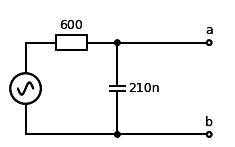

In [4]:
def rc_lowpass():
    c = circuit.Circuit(title="RC-tag")
    c.add_resistor("R1", n1="n_in", n2="n_out", value=600)
    c.add_capacitor("C1", n1="n_out", n2=c.gnd, value=210e-9)
    return c

with schem.Drawing() as d:
    V_in = d.add(elem.SourceSin(d='up'))
    R = d.add(elem.ResistorIEC(d='right', label='600'))
    d.add(elem.Dot())
    C = d.add(elem.Capacitor(d='down', botlabel='210n'))
    d.add(elem.Dot())
    d.add(elem.Line(to=V_in.start))
    d.add(elem.Line(d ='right', xy=R.end))
    d.add(elem.Dot(label='a', open=True))
    d.add(elem.Line(d='right', xy=C.end))
    d.add(elem.Dot(label='b', open=True))
    d.draw()

## 4-ed rendű Butterworth-féle aluláteresztő szűrő

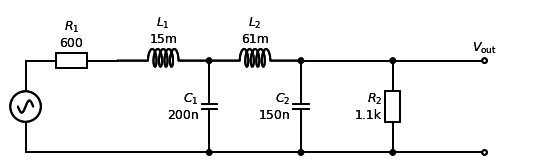

In [5]:
def butterworth_lowpass():
    c = circuit.Circuit(title="4-ed rendű Butterworth-féle aluláteresztő szűrő")
    c.add_resistor("R1", n1="n_in", n2="n2", value=600)
    c.add_inductor("L1", n1="n2", n2="n3", value=15e-3)
    c.add_capacitor("C1", n1="n3", n2=c.gnd, value=200e-9)
    c.add_inductor("L2", n1="n3", n2="n_out", value=61e-3)
    c.add_capacitor("C2", n1="n_out", n2=c.gnd, value=150e-9)
    c.add_resistor("R2", n1="n_out", n2=c.gnd, value=1.1e3)
    return c

with schem.Drawing() as d:
    V_in = d.add(elem.SourceSin(d='up'))
    R1 = d.add(elem.ResistorIEC(d='right', label='$R_1$\n600'))
    L1 = d.add(elem.Inductor2(d='right', label='$L_1$\n15m'))
    d.add(elem.Dot())
    C1 = d.add(elem.Capacitor(d='down', label='$C_1$\n200n'))
    d.add(elem.Dot())
    L2 = d.add(elem.Inductor2(d='right', xy=C1.start, label='$L_2$\n61m'))
    d.add(elem.Dot())
    C2 = d.add(elem.Capacitor(d='down', label='$C_2$\n150n'))
    d.add(elem.Dot())
    d.add(elem.Line(d='right', xy=C2.start))
    d.add(elem.Dot())
    R2 = d.add(elem.ResistorIEC(d='down', label='$R_2$\n1.1k'))
    d.add(elem.Dot())
    for i in range(4): d.add(elem.Line(d='left'))
    d.add(elem.Line(d='right', xy=R2.start))
    d.add(elem.Dot(label='$V_\mathrm{out}$', open=True))
    d.add(elem.Line(d='right', xy=R2.end))
    d.add(elem.Dot(open=True))
    d.draw()

## 4-ed rendű Butterworth-féle sáváteresztő szűrő

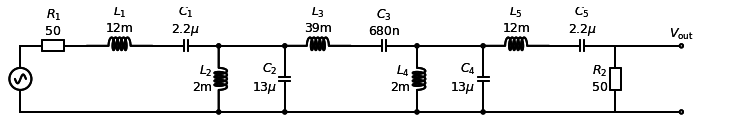

In [6]:
def butterworth_bandpass():
    c = circuit.Circuit('Butterworth-féle 1kHz-es sáváteresztő szűrő')
    c.add_resistor('R1', 'n_in', 'n2', 50.)
    c.add_inductor('L1', 'n2', 'n3', 12e-3)
    c.add_capacitor('C1', 'n3', 'n4', 2.2e-6)
    c.add_inductor('L2', 'n4', c.gnd, 2e-3)
    c.add_capacitor('C2', 'n4', c.gnd, 13e-6)
    c.add_inductor('L3', 'n4', 'n5', 39e-3)
    c.add_capacitor('C3', 'n5', 'n6', 680e-9)
    c.add_inductor('L4', 'n6', c.gnd, 2e-3)
    c.add_capacitor('C4', 'n6', c.gnd, 13e-6)
    c.add_capacitor('C5', 'n7', 'n_out', 2.2e-6)
    c.add_inductor('L5', 'n6', 'n7', 12e-3)
    c.add_resistor('R2', 'n_out', c.gnd, 50.)
    return c

with schem.Drawing() as d:
    V_in = d.add(elem.SourceSin(d='up'))
    R1 = d.add(elem.ResistorIEC(d='right', label='$R_1$\n50'))
    L1 = d.add(elem.Inductor2(d='right', label='$L_1$\n12m'))
    C1 = d.add(elem.Capacitor(d='right', label='$C_1$\n2.2$\mu$'))
    d.add(elem.Dot())
    L2 = d.add(elem.Inductor2(d='down', label='$L_2$\n2m'))
    d.add(elem.Dot())
    d.add(elem.Line(d='right', xy=L2.start))
    d.add(elem.Dot())
    C2 = d.add(elem.Capacitor(d='down', label='$C_2$\n13$\mu$'))
    d.add(elem.Dot())
    L3 = d.add(elem.Inductor2(d='right', xy=C2.start, label='$L_3$\n39m'))
    C3 = d.add(elem.Capacitor(d='right', label='$C_3$\n680n'))
    d.add(elem.Dot())
    L4 = d.add(elem.Inductor2(d='down', label='$L_4$\n2m'))
    d.add(elem.Dot())
    d.add(elem.Line(d='right', xy=L4.start))
    d.add(elem.Dot())
    C4 = d.add(elem.Capacitor(d='down', label='$C_4$\n13$\mu$'))
    d.add(elem.Dot())
    L5 = d.add(elem.Inductor2(d='right', xy=C4.start, label='$L_5$\n12m'))
    C5 = d.add(elem.Capacitor(d='right', label='$C_5$\n2.2$\mu$'))
    R2 = d.add(elem.ResistorIEC(d='down', label='$R_2$\n50'))
    for i in range(9): d.add(elem.Line(d='left'))
    d.add(elem.Line(d='right', xy=R2.start))
    d.add(elem.Dot(label='$V_\mathrm{out}$', open=True))
    d.add(elem.Line(d='right', xy=R2.end))
    d.add(elem.Dot(open=True))
    d.config(inches_per_unit=0.36)
    d.draw()

# Feladatok

## 1. részfeladat - Mérőjelek szimulációja

Analóg áramkörök kísérleti, szimulált és analitikus vizsgálatakor gyakran alkalmazunk ún. mérőjeleket. 

Írjunk függvényeket, melyek megvalósítják

* a tetszőleges frekvenciájú, amplitúdójú és fázisú szinuszos mérőjelet,
* a tetszőleges periódusidejű és amplitúdójú négyszögjelet,
* az egységimpulzust valamint
* az egységugrást.

A feladat későbbi részeinek megkönnyítése érdekében kövessük azt a szokást, hogy úgy írjuk meg ezeket a mérőjel-függvényeket, hogy akár egyszerre több időpontot is ki tudjanak értékelni, ha ezek a $t$ időpontok `array()`ben vannak eltárolva, és a függvény ezeket így kapja meg egyben.

Ábrázoljuk a mérőjeleket!

In [7]:
# mérőjeleket megvalósítő függvények
from scipy import signal

def sin(t, A = 1, omega = 1, phi = 0):
    return A*np.sin(omega*t + phi)

def square_wave(t,  A = 1, T = 1):
    return A*np.where(np.sin(2*np.pi*t/T) >= 0, A*0.5, -A*0.5)
    
def dirac(t, a = 0):
    return signal.unit_impulse(len(t), idx = np.abs(t - a).argmin())

def unit_step(t, a = 0):
    return (t >= 0).astype(float)

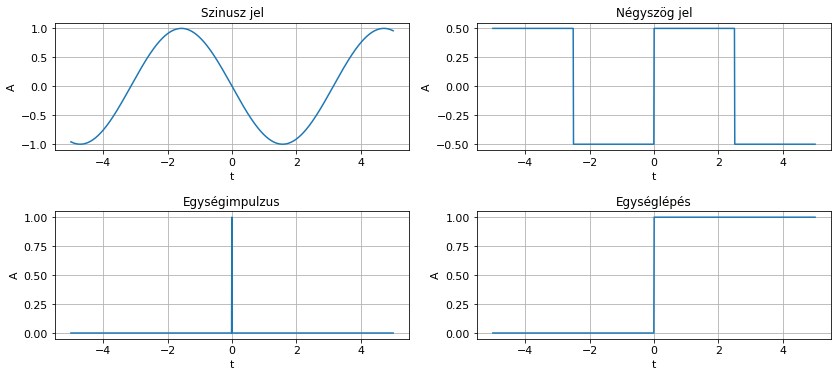

In [8]:
# ábrázolás
t = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

# Subplot 1
ax[0, 0].plot(t, sin(t, 1, 1, np.pi))
ax[0, 0].set_title("Szinusz jel")
ax[0, 0].set_xlabel('t')
ax[0, 0].set_ylabel('A')
ax[0, 0].grid()

# Subplot 2
ax[0, 1].plot(t, square_wave(t, 1, 5))
ax[0, 1].set_title("Négyszög jel")
ax[0, 1].set_xlabel('t')
ax[0, 1].set_ylabel('A')
ax[0, 1].grid()

# Subplot 3
ax[1, 0].plot(t, dirac(t, 0))
ax[1, 0].set_title("Egységimpulzus")
ax[1, 0].set_xlabel('t')
ax[1, 0].set_ylabel('A')
ax[1, 0].grid()

# Subplot 4
ax[1, 1].plot(t, unit_step(t))
ax[1, 1].set_title("Egységlépés")
ax[1, 1].set_xlabel('t')
ax[1, 1].set_ylabel('A')
ax[1, 1].grid()

# Térköz és címek beállítása
plt.tight_layout(pad=2)
plt.subplots_adjust(top=0.85)

## 2. rész - Mérőjelekre adott válaszok analízise

Szimuláljuk a mérőjelek hatását a fenti függvényekben definiált áramkörökre:

* RC aluláteresztő szűrő,
* Butterworth-féle aluláteresztő szűrő,
* Butterworth-féle 1kHz-es sáváteresztő szűrő.

Segítségül a hívási szintaxist megmutatjuk az alábbi példán, ahol az RC aluláteresztő szűrő válaszfüggvényét szimuláljuk 1 kHz-es szinuszos gerjesztés esetén.

Minhárom példa áramkör alapparaméterei olyanok, hogy a 600 Hz - 5 kHz tartományban van a lényegi viselkedés, de szebb ábráért érdemes valamivel tovább menni.

A helyes működés érdekében okosan kell a mérőjelek paramétereit megválasztani. Az áramkörök érdekes tartományát figyelembe véve, megfelelő időskálán vizsgáljuk a működést, és a periódikus jelek frekvenciáját is helyesen válasszuk meg! Az is előfordulhat, hogy a példában rögzített értékeken módosítani kell,  például a `run_transient()`ben megadott `tstop` értékén.
Olyan hosszan ábrázoljuk, amíg lényeges változást látunk, pl. lecseng a jel, vagy periódikus, de az amplitúdója változik.

A szimulációt elvégző `run_transient()` függvény második argumentumaként várja a bemenő jelet leíró függvényt.
Itt két probléma léphet fel:

(i) Egyik probléma, hogy ez a függvény csak egy argumentumú lehet, az idő az argumentuma. Tehát az első feladatban általánosan elkészített függvényeket, amelyek további paramétereket is várnak, ügyesen kell ennek a függvénynek átadni. 
A szinuszos mérőjel esetén ezt úgy is megoldhatjuk, hogy a kért függvényt ún. `lambda` kifejezéssel helyettesítjük, vagy aki jártas a `python` dekorátorok világában, azokkal is megoldhatja. A lambda kifejezéses megoldásra példa az alábbi:

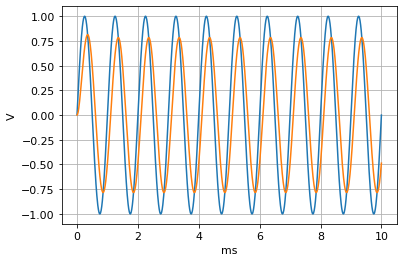

In [9]:
c = rc_lowpass()
t, s, r = run_transient(c, lambda t: np.sin(1000*2*np.pi*t), tstart = 0, tstop = 10e-3)

plt.plot(t*1e3, s)
plt.plot(t*1e3, r)
plt.xlabel("ms")
plt.ylabel("V")
plt.grid()

(ii) Egy másik probléma az, hogy az áramkörszimulátor hibát ad, ha a vizsgáló jelben szakadás vagy ugrás van. 
Így mind az egységurás, mind az impulzus esetén ügyeljünk arra, hogy ezeket a jeleket megfelelően közelítsük. 
Célszerű a mérőjeleket *folytonossá* alakítani például az `interp1d` osztály segítségével. Ezzel egyben a paraméterátadással kapcsolatos kérdés is megoldható. Ha kiolvassuk a bemenő jel értékeit egy elég sűrű pontsorozaton, akkor az `interp1d` függvény segítségével pl lineárisan interpolálhatjuk ezeket az értékeket. Az `interp1d` által visszaadott függvényt meg tudjuk hívni a megadott tartományon belüli tetszőleges értékkel az interpolált értékek kiolvasása céljából. 

Az interpolált függvényt közvetlen beadhatjuk a `run_transient` függvénynek a korábbi példa szerinti lambda forma helyén. (Persze ekkor a beírt függvény neve után ne írjunk zárójeleket, mert a függvény azonosítóját kell átadni, nem egy lefuttatásának eredményét.) Figyeljünk, hogy a feladat megoldásához az interpolált függvényt egy megfelelő időskálájú értéksorozatból hozzuk létre.

Meg kell említeni még, hogy a `run_transient()` kicsivel `tstop` után is kiértékelheti a bemenő jel függvényét, 
tehát erre fel kell készíteni az implementációt, hogy ilyenkor se keletkezzen hiba.

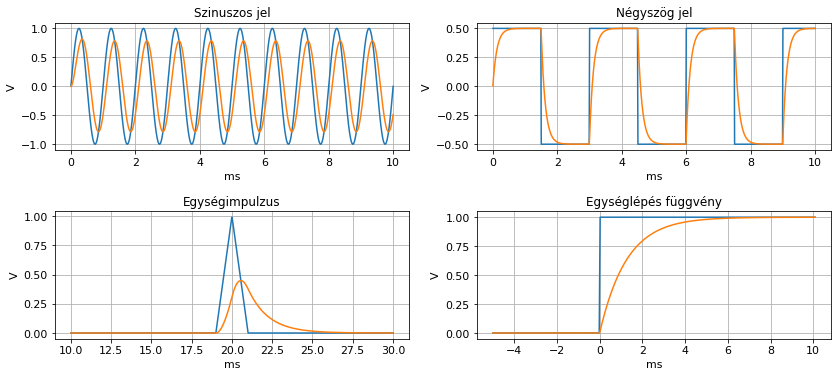

In [10]:
# Mérőjelek alkalmazása az RC aluláteresztő szűrőre

# A szinuszos jel:
t0 = np.linspace(0, 1, 10**5)
c = rc_lowpass()
t0, s0, r0 = run_transient(c, lambda t0: sin(t0, omega = 2*np.pi*1e3), tstart = 0, tstop = 10e-3)

# A négyszög jel:
t1 = np.linspace(0, 1, 10**5)
c = rc_lowpass()
t1, s1, r1 = run_transient(c, interp1d(t1, square_wave(t1, A = 1, T = 0.003)), tstart = 0, tstop = 10e-3)

# Az egységimpulzus
t2 = np.linspace(0, 1, 10**4)
c = rc_lowpass()
t2, s2, r2 = run_transient(c, interp1d(t2, dirac(t2, 2*10e-4)), tstart = 10e-4, tstop = 3*10e-4)

# Az egységlépés függvény:
t3 = np.linspace(-1, 1, 5*10**5)
c = rc_lowpass()
t3, s3, r3 = run_transient(c, interp1d(t3, unit_step(t3, a = 0)), tstart = -0.0005, tstop = 10e-4)

# Ábrák inicializálása
fig, axs = plt.subplots(2, 2, figsize = (12, 6))

# A szinuszos jel
axs[0, 0].plot(t0*1e3, s0)
axs[0, 0].plot(t0*1e3, r0)
axs[0, 0].set_xlabel("ms")
axs[0, 0].set_ylabel("V")
axs[0, 0].set_title("Szinuszos jel")
axs[0, 0].grid()

# A négyszög jel
axs[0, 1].plot(t1*1e3, s1)
axs[0, 1].plot(t1*1e3, r1)
axs[0, 1].set_xlabel("ms")
axs[0, 1].set_ylabel("V")
axs[0, 1].set_title("Négyszög jel")
axs[0, 1].grid()

# Az egységimpulzus
axs[1, 0].plot(t2*1e4, s2, label = '')
axs[1, 0].plot(t2*1e4, r2)
axs[1, 0].set_xlabel("ms")
axs[1, 0].set_ylabel("V")
axs[1, 0].set_title("Egységimpulzus")
axs[1, 0].grid()

# Az egységlépés függvény
axs[1, 1].plot(t3*1e4, s3, label = '')
axs[1, 1].plot(t3*1e4, r3)
axs[1, 1].set_xlabel("ms")
axs[1, 1].set_ylabel("V")
axs[1, 1].set_title("Egységlépés függvény")
axs[1, 1].grid()

# Térköz és címek beállítása
plt.tight_layout(pad = 2)
plt.subplots_adjust(top = 0.85)

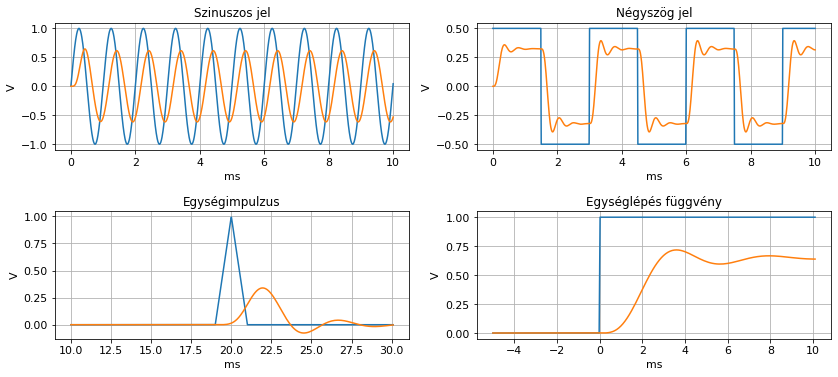

In [11]:
# Mérőjelek alkalmazása Butterworth-féle aluláteresztő szűrőre
cbl = butterworth_lowpass()

# A szinuszos jel:
t0 = np.linspace(0, 1, 10**5)
t0, s0, r0 = run_transient(cbl, lambda t0: sin(t0, omega = 2*np.pi*1e3), tstart = 0, tstop = 10e-3)

# A négyszög jel:
t1 = np.linspace(0, 1, 10**5)
t1, s1, r1 = run_transient(cbl, interp1d(t1, square_wave(t1, A = 1, T = 0.003)), tstart = 0, tstop = 10e-3)

# Az egységimpulzus
t2 = np.linspace(0, 1, 10**4)
t2, s2, r2 = run_transient(cbl, interp1d(t2, dirac(t2, 2*10e-4)), tstart = 10e-4, tstop = 3*10e-4)

# Az egységlépés függvény:
t3 = np.linspace(-1, 1, 5*10**5)
t3, s3, r3 = run_transient(cbl, interp1d(t3, unit_step(t3, a = 0)), tstart = -0.0005, tstop = 10e-4)

# Ábrák inicializálása
fig, axs = plt.subplots(2, 2, figsize = (12, 6))

# A szinuszos jel
axs[0, 0].plot(t0*1e3, s0)
axs[0, 0].plot(t0*1e3, r0)
axs[0, 0].set_xlabel("ms")
axs[0, 0].set_ylabel("V")
axs[0, 0].set_title("Szinuszos jel")
axs[0, 0].grid()

# A négyszög jel
axs[0, 1].plot(t1*1e3, s1)
axs[0, 1].plot(t1*1e3, r1)
axs[0, 1].set_xlabel("ms")
axs[0, 1].set_ylabel("V")
axs[0, 1].set_title("Négyszög jel")
axs[0, 1].grid()

# Az egységimpulzus
axs[1, 0].plot(t2*1e4, s2, label = '')
axs[1, 0].plot(t2*1e4, r2)
axs[1, 0].set_xlabel("ms")
axs[1, 0].set_ylabel("V")
axs[1, 0].set_title("Egységimpulzus")
axs[1, 0].grid()

# Az egységlépés függvény
axs[1, 1].plot(t3*1e4, s3, label = '')
axs[1, 1].plot(t3*1e4, r3)
axs[1, 1].set_xlabel("ms")
axs[1, 1].set_ylabel("V")
axs[1, 1].set_title("Egységlépés függvény")
axs[1, 1].grid()

# Térköz és címek beállítása
plt.tight_layout(pad = 2)
plt.subplots_adjust(top = 0.85)

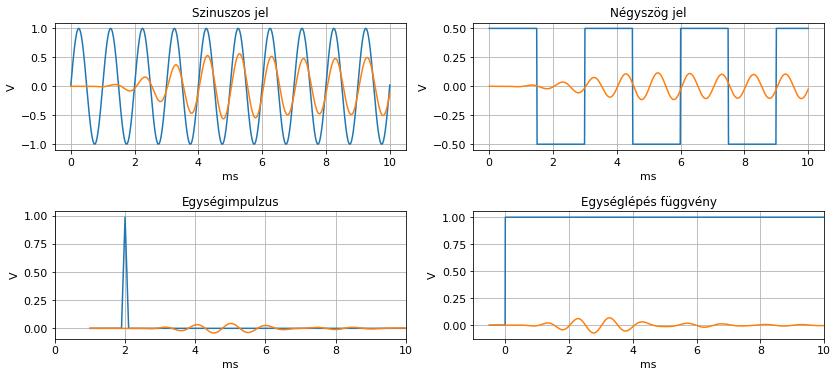

In [12]:
# Mérőjelek alkalmazása Butterworth-féle sáváteresztő szűrőre
cbb = butterworth_bandpass()

# A szinuszos jel:
t0 = np.linspace(0, 1, 10**5)
t0, s0, r0 = run_transient(cbb, lambda t0: sin(t0, omega = 2*np.pi*1e3), tstart = 0, tstop = 10e-3)

# A négyszög jel:
t1 = np.linspace(0, 1, 10**5)
t1, s1, r1 = run_transient(cbb, interp1d(t1, square_wave(t1, A = 1, T = 0.003)), tstart = 0, tstop = 10e-3)

# Az egységimpulzus
t2 = np.linspace(0, 1, 10**4)
t2, s2, r2 = run_transient(cbb, interp1d(t2, dirac(t2, 2*10e-4)), tstart = 10e-4, tstop = 5*10e-3)

# Az egységlépés függvény:
t3 = np.linspace(-1, 1, 5*10**5)
t3, s3, r3 = run_transient(cbb, interp1d(t3, unit_step(t3, a = 0)), tstart = -0.0005, tstop = 5*10e-3)

# Ábrák inicializálása
fig, axs = plt.subplots(2, 2, figsize = (12, 6))

# A szinuszos jel
axs[0, 0].plot(t0*1e3, s0)
axs[0, 0].plot(t0*1e3, r0)
axs[0, 0].set_xlabel("ms")
axs[0, 0].set_ylabel("V")
axs[0, 0].set_title("Szinuszos jel")
axs[0, 0].grid()

# A négyszög jel
axs[0, 1].plot(t1*1e3, s1)
axs[0, 1].plot(t1*1e3, r1)
axs[0, 1].set_xlabel("ms")
axs[0, 1].set_ylabel("V")
axs[0, 1].set_title("Négyszög jel")
axs[0, 1].grid()

# Az egységimpulzus
axs[1, 0].plot(t2*1e3, s2, label = '')
axs[1, 0].plot(t2*1e3, r2)
axs[1, 0].set_xlabel("ms")
axs[1, 0].set_ylabel("V")
axs[1, 0].set_title("Egységimpulzus")
axs[1, 0].set_xlim(0, 10)
axs[1, 0].grid()

# Az egységlépés függvény
axs[1, 1].plot(t3*1e3, s3, label = '')
axs[1, 1].plot(t3*1e3, r3)
axs[1, 1].set_xlabel("ms")
axs[1, 1].set_ylabel("V")
axs[1, 1].set_title("Egységlépés függvény")
axs[1, 1].set_xlim(-1, 10)
axs[1, 1].grid()

# Térköz és címek beállítása
plt.tight_layout(pad = 2)
plt.subplots_adjust(top = 0.85)

## 3. rész - Átviteli függvény meghatározása

Szimuláljuk a két összetettebb rendszer kimenetét különböző frekvenciájú szinuszos bemenőjelek esetén. Határozzuk meg a kimenet amplitúdóját és fáziseltolódását a frekvencia függvényében. Ügyeljünk arra, hogy a kimeneti jel amplitúdóját a tranziens szakasz eltűnése után kell megmérni!

Ábrázoljuk az átviteli függvényeket és az ábrák elemzésével összegezzük a tapasztaltakat.

  0%|          | 0/100 [00:00<?, ?it/s]

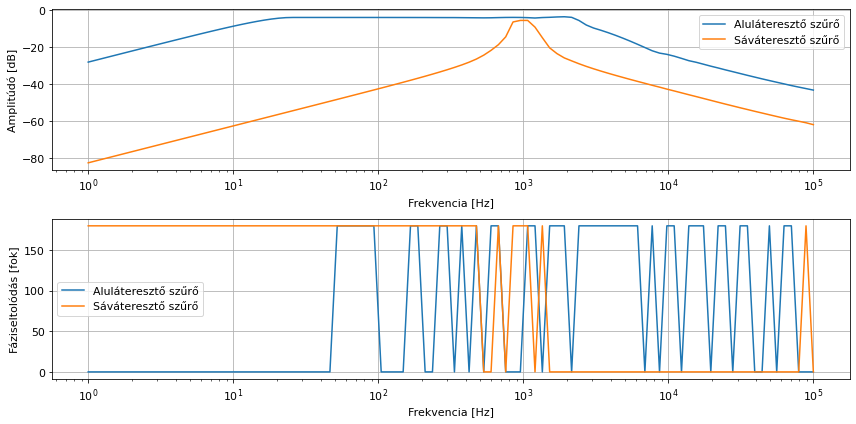

In [23]:
# Szűrők definiálása
from tqdm.auto import tqdm

lowpass_filter = butterworth_lowpass()
bandpass_filter = butterworth_bandpass()

# Bemeneti jel frekvenciái
frequencies = np.logspace(0, 5, 100)

# Kimeneti jel amplitúdója és fáziseltolódása
output_amplitudes_lowpass = []
output_phases_lowpass = []

output_amplitudes_bandpass = []
output_phases_bandpass = []

for freq in tqdm(frequencies):
    # Aluláteresztő szűrő
    fun = lambda t: sin(t, A=1, omega=2*np.pi*freq, phi=0)
    time, source, response = run_transient(lowpass_filter, fun)
    output_amplitudes_lowpass.append(np.max(np.abs(response)))
    output_phases_lowpass.append(np.angle(response[-1]))

    # Sáváteresztő szűrő
    fun = lambda t: sin(t, A=1, omega=2*np.pi*freq, phi=0)
    time, source, response = run_transient(bandpass_filter, fun)
    output_amplitudes_bandpass.append(np.max(np.abs(response)))
    output_phases_bandpass.append(np.angle(response[-1]))

# Átviteli függvények ábrázolása
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.semilogx(frequencies, 20*np.log10(output_amplitudes_lowpass), label="Aluláteresztő szűrő")
plt.semilogx(frequencies, 20*np.log10(output_amplitudes_bandpass), label="Sáváteresztő szűrő")
plt.xlabel("Frekvencia [Hz]")
plt.ylabel("Amplitúdó [dB]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogx(frequencies, np.degrees(output_phases_lowpass), label="Aluláteresztő szűrő")
plt.semilogx(frequencies, np.degrees(output_phases_bandpass), label="Sáváteresztő szűrő")
plt.xlabel("Frekvencia [Hz]")
plt.ylabel("Fáziseltolódás [fok]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
1

In [14]:
# Átviteli függvény meghatározása és ábrázolása a Butterworth-féle sáváteresztő szűrőre

#### Tapasztalatok szövegezése

## 4. rész - Az impulzusválasz tulajdonságainak vizsgálata

## 4.a
Az elméletből ismert, hogy a 3. részben meghatározott átviteli függvény és a fázistolás frekvenciafüggése önmagában az impulzusválaszból  megkapható, mégpedig az impulzusválasz Fourier transzformálásával.
Próbáljuk ezt ki a Butterworth-féle sáváteresztő szűrőn, azaz
szimuláljuk e szűrő impulzusra adott válaszát elegendően hosszan! Határozzuk meg az impulzusválasz Fourier-transzformáltját!
Állítsuk elő belőle az átviteli függvényt, és ábrázoljuk egy ábrában az előző feladatban meghatározott átviteli függvénnyel!

Itt hasonló problémával találkozunk, mint amilyennel egy korábbi feladatnál. Mivel a szimuláció időben nem egyenletes lépésközű adatsort ad, ahhoz, hogy a Fourier-transzformáltját tudjuk venni, át kell mintavételezni egyenletes lépésközzel. Ezt megint az `interp1d` függvénnyel tudjuk megtenni. A jelalakot most érdemes pontosabban közelíteni egy harmadrendű spline segítségével, amely az eredeti adatpontokban simán folytatódó függvényalakot valósít meg.

In [15]:
# Átinterpolált impulzusválasz ábrája

In [16]:
# Sáváteresztő szűrő impulzusválaszának Fourier-transzformáltja
# összehasonlítva a 3. részben kapott átviteli függvénnyel

#### Mit várunk el, és mit taptasztaltunk?

## 4.b
Szintén ismert, hogy egy lineáris rendszernek tetszőlegesen választott bemenő jelre való válasza megkapható úgy is, ha a rendszerről csak az impulzusválaszát tudjuk. Az impulzusválasz és a választott bemenő jel konvolúcióját kell kiszámolni.
Próbáljuk ezt ki a Butterworth-féle aluláteresztő szűrő és négyszögjel esetére!

Az említett konvolúciót a numpy.convolve függvény segítségével tudjuk kiszámítani. Ehhez megint egyenletes, és egymással azonos lépésközzel kell venni a konvolváltatott jeleket, tehát az impulzusválaszt át kell mintavételezni egyenletes lépésközzel.
Bemenő jelként használjuk a 2. részben is használt periódikus négyszögjelet. Tehát vegyük a korábban már használt négyszögjel értékeit az előző lépésben meghatározott időbeli rácson. Hasonlítsuk össze a konvolúcióra kapott eredményt egy ábrában a 2. feladatrészben a négyszögjelre kapott válasszal!

In [17]:
# Átinterpolált impulzusválasz ábrája

In [18]:
# Az impulzusválasz és a négyszögjel konvolúciójának meghatározása

## <font color='green5'>5. rész - Zajok vizsgálata</font> 

Állítsunk elő kétféle zajt, és ábrázoljuk:

* uniform zaj: az időfüggő jel értéke a [-1,1] intervallumon egyenletes eloszlásból származik
* normál eloszlású zaj: a jel értéke 0 átlagú és egységnyi szórású normál eloszlás szerinti

E zajokat $100 ms$ hosszan állítsuk elő, s ebben legyen $8-10000$ adatpontunk!

Utána határozzuk meg ezek autokorrelációs függvényeit és ábrázoljuk!

Határozzuk meg és ábrázoljuk e zajok Fourier spektrumát is!

Vizsgáljuk meg, hogy e zajokból milyen jel keletkezik a sáváteresztő szűrő hatására!
Ábrázoljuk előbb a kimenő jeleket! Utána pedig a kimenő jel Fourier transzformáltját úgy, hogy mindkét zaj esetében egy-egy ábrában hasonlítsuk össze a 3. részben kapott átviteli függvénnyel!

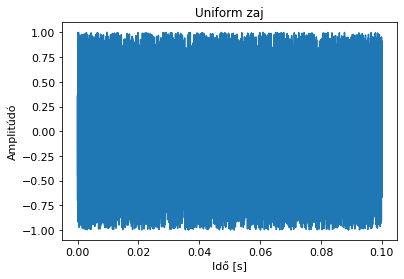

In [19]:
# időtengely
t = np.linspace(0, 0.1, 10000)

# uniform zaj
uniform_noise = np.random.uniform(-1, 1, size=10000)

# ábrázolás
plt.plot(t, uniform_noise)
plt.title('Uniform zaj')
plt.xlabel('Idő [s]')
plt.ylabel('Amplitúdó')
plt.show()


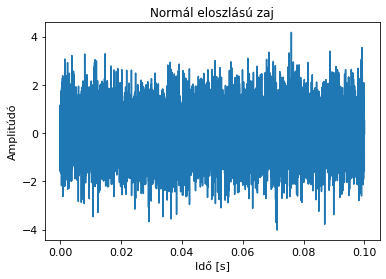

In [20]:
# normál eloszlású zaj
normal_noise = np.random.normal(0, 1, size=10000)

# ábrázolás
plt.plot(t, normal_noise)
plt.title('Normál eloszlású zaj')
plt.xlabel('Idő [s]')
plt.ylabel('Amplitúdó')
plt.show()


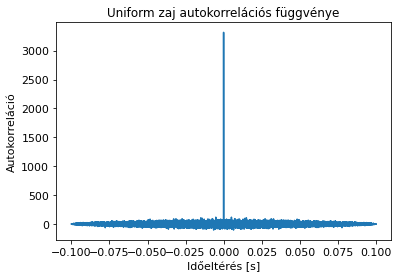

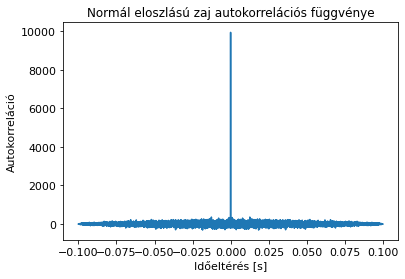

In [21]:
from scipy.signal import correlate

# uniform zaj autokorrelációs függvénye
uniform_autocorr = correlate(uniform_noise, uniform_noise, mode='full')

# normál eloszlású zaj autokorrelációs függvénye
normal_autocorr = correlate(normal_noise, normal_noise, mode='full')

# időtengely az autokorrelációs függvényekhez
tau = np.linspace(-0.1, 0.1, 19999)

# ábrázolás
plt.plot(tau, uniform_autocorr)
plt.title('Uniform zaj autokorrelációs függvénye')
plt.xlabel('Időeltérés [s]')
plt.ylabel('Autokorreláció')
plt.show()

plt.plot(tau, normal_autocorr)
plt.title('Normál eloszlású zaj autokorrelációs függvénye')
plt.xlabel('Időeltérés [s]')
plt.ylabel('Autokorreláció')
plt.show()


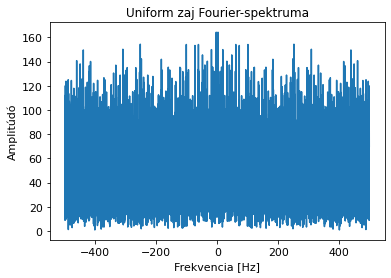

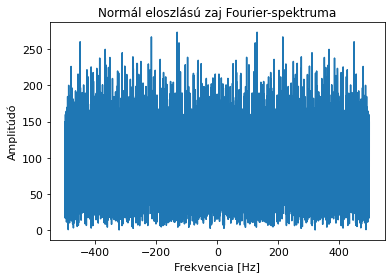

In [22]:
# uniform zaj Fourier-transzformáltja
uniform_spectrum = np.fft.fftshift(np.fft.fft(uniform_noise))

# normál eloszlású zaj Fourier-transzformáltja
normal_spectrum = np.fft.fftshift(np.fft.fft(normal_noise))

# frekvenciatengely
f = np.linspace(-500, 499, 10000)

# ábrázolás
plt.plot(f, np.abs(uniform_spectrum))
plt.title('Uniform zaj Fourier-spektruma')
plt.xlabel('Frekvencia [Hz]')
plt.ylabel('Amplitúdó')
plt.show()

plt.plot(f, np.abs(normal_spectrum))
plt.title('Normál eloszlású zaj Fourier-spektruma')
plt.xlabel('Frekvencia [Hz]')
plt.ylabel('Amplitúdó')
plt.show()
